In [3]:
import numpy as np
from mealpy.bio_based import BBO
from mealpy import PSO, BinaryVar
from typing import List, Tuple

In [ ]:

class MaximalCoveringLocation(object):

    def __init__(self,
            points: List[Tuple[float, float]],
            demands: List[float],
            facilities: list[int],
            max_facilities: int,
            coverage_radius: float,
        ) -> None:
        self.num_locations = len(facilities)
        self.num_demand_points = len(points)
        self.dist_matrix_euclidean = np.zeros((self.num_demand_points, self.num_demand_points), np.float64)
        #self.dist_matrix_manhattan = np.zeros((self.num_demand_points, self.num_demand_points), np.float64)
        for i in range(len(points)):
            for j in range(len(points)):
                self.dist_matrix_euclidean[i, j] = np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2)
                #self.dist_matrix_manhattan[i, j] = abs(points[i][0] - points[j][0]) + abs(points[i][1] - points[j][1])

        self.facilities = np.array(facilities, dtype=np.int32)
        self.distances = self.dist_matrix_euclidean
        self.demands = np.array(demands, dtype=np.float64)
        self.max_facilities = max_facilities
        self.coverage_radius = coverage_radius

    def objective_function(self,
            solution: np.ndarray
        ):
        facilities = solution.copy()
        coverage = np.zeros(self.num_demand_points)

        for i in facilities:
            if facilities[int(i)] == 1:
                for j in range(self.num_demand_points):
                        if coverage[j] == 1:
                            continue
                        if self.distances[int(i),j] <= self.coverage_radius:
                            coverage[j] = 1
        fitness = np.sum(coverage * self.demands)
        penalty = 0
        if np.sum(facilities) > self.max_facilities:
            penalty = np.sum(facilities) - self.max_facilities
        return -fitness + penalty * 1000

    def solve(self, ):
        problem_constrained = {
            "obj_func": self.objective_function,
            "bounds": BinaryVar(n_vars=self.num_locations),
            "minmax": "min",
        }
        model = BBO.OriginalBBO(epoch=500, pop_size=50)
        result =  model.solve(problem_constrained)
        return {
            'id': result.id,
            'target': list(result.target.objectives),
            'Fitness': result.target.fitness,
            'solution': list(result.solution)
        }

In [ ]:
points = [(0, 0), (0, 1), (0, 2),
          (1, 0), (1, 1), (1, 2),
          (2, 0), (2, 1), (2, 2)]

demands = [ 4, 5, 2,
        2, 1, 4,
        2, 2, 1]

facilities = [ 0, 2, 6]

coverage_radius = 1
max_facilities = 2

In [ ]:
model = MaximalCoveringLocation(
    points=points,
    demands=demands,
    facilities=facilities,
    max_facilities=2,
    coverage_radius=1
)

In [ ]:
result = model.solve()

INFO:mealpy.bio_based.BBO.OriginalBBO:Solving single objective optimization problem.
INFO:mealpy.bio_based.BBO.OriginalBBO:>>>Problem: P, Epoch: 1, Current best: -14.0, Global best: -14.0, Runtime: 0.01361 seconds
INFO:mealpy.bio_based.BBO.OriginalBBO:>>>Problem: P, Epoch: 2, Current best: -14.0, Global best: -14.0, Runtime: 0.01538 seconds
INFO:mealpy.bio_based.BBO.OriginalBBO:>>>Problem: P, Epoch: 3, Current best: -14.0, Global best: -14.0, Runtime: 0.01468 seconds
INFO:mealpy.bio_based.BBO.OriginalBBO:>>>Problem: P, Epoch: 4, Current best: -14.0, Global best: -14.0, Runtime: 0.01269 seconds
INFO:mealpy.bio_based.BBO.OriginalBBO:>>>Problem: P, Epoch: 5, Current best: -14.0, Global best: -14.0, Runtime: 0.01488 seconds
INFO:mealpy.bio_based.BBO.OriginalBBO:>>>Problem: P, Epoch: 6, Current best: -14.0, Global best: -14.0, Runtime: 0.01438 seconds
INFO:mealpy.bio_based.BBO.OriginalBBO:>>>Problem: P, Epoch: 7, Current best: -14.0, Global best: -14.0, Runtime: 0.03289 seconds
INFO:mealpy.

In [ ]:
result


{'id': 53556, 'target': [-14.0], 'Fitness': -14.0, 'solution': [1.0, 1.0, 0.0]}

In [ ]:

# Parámetros del problema CVPRTW
NUM_CUSTOMERS = 10  # Número de clientes
VEHICLE_CAPACITY = 15  # Capacidad del vehículo

# Datos de ejemplo para el CVPRTW (distancias, demandas, ventanas de tiempo)
distances = np.random.rand(NUM_CUSTOMERS+1, NUM_CUSTOMERS+1)  # Distancias entre nodos (incluye el depósito)
demands = np.random.randint(1, 10, size=(NUM_CUSTOMERS))  # Demandas de los clientes
time_windows = [(0, 50)] + [(np.random.randint(0, 30), np.random.randint(30, 50)) for _ in range(NUM_CUSTOMERS)]  # Ventanas de tiempo

# Función objetivo para CVPRTW
def objective_function(solution):
    total_distance = 0
    current_time = 0
    current_capacity = 0

    # Recorrer la solución, que representa una ruta
    for i in range(len(solution) - 1):
        current_node = solution[i]
        next_node = solution[i+1]

        # Actualizar la distancia recorrida
        total_distance += distances[current_node][next_node]

        # Actualizar el tiempo de llegada y verificar ventanas de tiempo
        current_time += distances[current_node][next_node]
        earliest, latest = time_windows[next_node]
        if current_time < earliest:
            current_time = earliest  # Esperar hasta que abra la ventana de tiempo
        if current_time > latest:
            return np.inf  # Penalización por no cumplir la ventana de tiempo

        # Verificar la capacidad del vehículo
        if next_node != 0:  # Si no es el depósito
            current_capacity += demands[next_node - 1]
            if current_capacity > VEHICLE_CAPACITY:
                return np.inf  # Penalización por exceder la capacidad

    return total_distance

# Restricciones y definición del problema
problem_cvprtw = {
    "obj_func": objective_function,
    # Solución: nodos visitados, representados por variables discretas
    "bounds": IntVar(lb=[0]*(NUM_CUSTOMERS+1), ub=[NUM_CUSTOMERS]*(NUM_CUSTOMERS+1)),
    "minmax": "min",
}

# Resolver el problema usando el algoritmo adecuado: Genetic Algorithm (GA)
model = GA.BaseGA(epoch=500, pop_size=30)  # Algoritmo genético (GA) que trabaja bien con variables discretas
best_solution, best_fitness = model.solve(problem=problem_cvprtw)

print(f"Mejor solución: {best_solution}")
print(f"Mejor fitness: {best_fitness}")

ImportError: cannot import name 'IntVar' from 'mealpy' (/usr/local/lib/python3.10/dist-packages/mealpy/__init__.py)

In [4]:
import numpy as np

# Velocidad por defecto del vehiculo en km/h
VD = 40

# Flete en dolars
f = 15

# Consumo de combustible del
#vehiculo colector en litros por km (l/km).
CC = 0.35

#patients
N = np.array([
    0, #0 warehouse
    1, #1
    2, #2
    3, #3
    4, #4
    5, #5
    6, #6
    7, #7
    8, #8
    9, #9
    10, #10
    11, #11
    12, #12
    13, #13
])


#vehicles
K = np.array([
    0,
    1,
    2,
])


coords = np.array([
        [90,  85], #1
        [75,  76], #2
        [96,  44], #3
        [50,  5],  #4
        [49,  8],  #5
        [13,  7],  #6
        [29,  89], #7
        [58,  30], #8
        [70,  39], #9
        [14,  24], #10
        [25,  39], #11
        [40,  25], #12
        [90,  85], #13
])


demands = np.array([
    0,  #1
    10, #2
    30, #3
    10, #4
    10, #5
    10, #6
    20, #7
    20, #8
    20, #9
    10, #10
    10, #11
    10, #12
    0   #13
])

#time windows
a = np.array([
    4,
    7,
    0,
    0,
    7,
    7,
    0,
    0,
    0,
    0,
    7,
    5,
    4,
])

b = np.array([
    15,
    24,
    24,
    7,
    24,
    24,
    7,
    24,
    24,
    24,
    24,
    14,
    15,
])

service_time = np.array([
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0
])

# Capacidad máxima del tanque de combustible
# del vehiculo colector.
T = np.array([
    15,
    15,
    15,
])

# Emisión de CO2 del vehiculo colector en
# gr/l de combustible del vehiculo.
EM = np.array([
    2.7,
    2.7,
    2.7,
])

# capacidad de los vehiculos k = v1, v2, v3.
Q_MAX = np.array([
	80,
	80,
	80,
])

In [5]:

class CVRPTW(object):

    def __init__(self,
            points: List[Tuple[float, float]],
            demands: List[float],
            facilities: list[int],
            max_facilities: int,
            coverage_radius: float,
        ) -> None:

        self.num_locations = len(facilities)
        self.num_demand_points = len(points)
        self.dist_matrix_euclidean = np.zeros((self.num_demand_points, self.num_demand_points), np.float64)
        #self.dist_matrix_manhattan = np.zeros((self.num_demand_points, self.num_demand_points), np.float64)
        for i in range(len(points)):
            for j in range(len(points)):
                self.dist_matrix_euclidean[i, j] = np.sqrt((points[i][0] - points[j][0])**2 + (points[i][1] - points[j][1])**2)
                #self.dist_matrix_manhattan[i, j] = abs(points[i][0] - points[j][0]) + abs(points[i][1] - points[j][1])

        self.facilities = np.array(facilities, dtype=np.int32)
        self.distances = self.dist_matrix_euclidean
        self.demands = np.array(demands, dtype=np.float64)
        self.max_facilities = max_facilities
        self.coverage_radius = coverage_radius

    def objective_function( self, x: np.ndarray):


        def violate(value):
          return 0 if value <= 0 else value



        facilities = solution.copy()
        coverage = np.zeros(self.num_demand_points)

        for i in facilities:
            if facilities[int(i)] == 1:
                for j in range(self.num_demand_points):
                        if coverage[j] == 1:
                            continue
                        if self.distances[int(i),j] <= self.coverage_radius:
                            coverage[j] = 1
        fitness = np.sum(coverage * self.demands)
        penalty = 0
        if np.sum(facilities) > self.max_facilities:
            penalty = np.sum(facilities) - self.max_facilities
        return -fitness + penalty * 1000


    def solve(self, ):
        problem_constrained = {
            "obj_func": self.objective_function,
            "bounds": BinaryVar(n_vars=self.num_atms),
            "minmax": "min",
        }

        model = BBO.OriginalBBO(epoch=500, pop_size=50)
        result =  model.solve(problem_constrained)
        return {
            'id': result.id,
            'target': list(result.target.objectives),
            'Fitness': result.target.fitness,
            'solution': list(result.solution)
        }

In [ ]:
from mealpy.evolutionary_based import GA
from mealpy.utils.problem import Problem
from mealpy.utils.space import FloatVar, IntegerVar
import numpy as np

# Definir la función objetivo
def objective_function(solution):
    return np.sum(solution ** 2)

# Parámetros del problema
problem_size = 10

# Definir los límites como variables flotantes
bounds = [FloatVar(-5, 5) for _ in range(problem_size)] + [IntegerVar(-5,5) for _ in range(problem_size)]

# Crear una instancia de problema directamente usando la clase Problem
problem = Problem(
    obj_func=objective_function,  # Función objetivo
    bounds=bounds,  # Limites definidos como FloatVar
    minmax="min",  # Minimización
    verbose=True,  # Mostrar progreso
    problem_size=problem_size*2  # Tamaño del problema
)

# Parámetros del algoritmo
epoch = 1000              # Número de iteraciones
pop_size = 50             # Tamaño de la población

# Crear el algoritmo GA con el problema
model = GA.BaseGA(problem=problem, epoch=epoch, pop_size=pop_size)

# Resolver el problema
best = model.solve(problem=problem)

In [ ]:
print(f"Mejor solución: {best.solution}")
# print(f"Mejor fitness: {best.}")


Mejor solución: [ 0.02200943 -0.00921245 -0.00798745 -0.00107385  0.0028234   0.006136
  0.00601625  0.00176402  0.0154981   0.01347037  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


Ruta para el vehículo 0:
 0 Time(0) Load(0) ATMs Visited(0) -> 0
Distancia de la ruta: 0.00 unidades
Costo fijo de la ruta: 0
Costo total de la ruta: 0.00

Ruta para el vehículo 1:
 1 Time(0) Load(0) ATMs Visited(0) -> 2 Time(60) Load(0) ATMs Visited(0) -> 1
Distancia de la ruta: 14.14 unidades
Costo fijo de la ruta: 100
Costo total de la ruta: 114.14

Ruta para el vehículo 2:
 0 Time(0) Load(0) ATMs Visited(0) -> 4 Time(90) Load(0) ATMs Visited(0) -> 3 Time(120) Load(10) ATMs Visited(1) -> 0
Distancia de la ruta: 20.25 unidades
Costo fijo de la ruta: 200
Costo total de la ruta: 220.25

Distancia total de todas las rutas: 34.40 unidades
Costo fijo total de todas las rutas: 300
Costo total de todas las rutas: 334.40


<ipython-input-14-4d6c0740574b>:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', data['num_vehicles'])


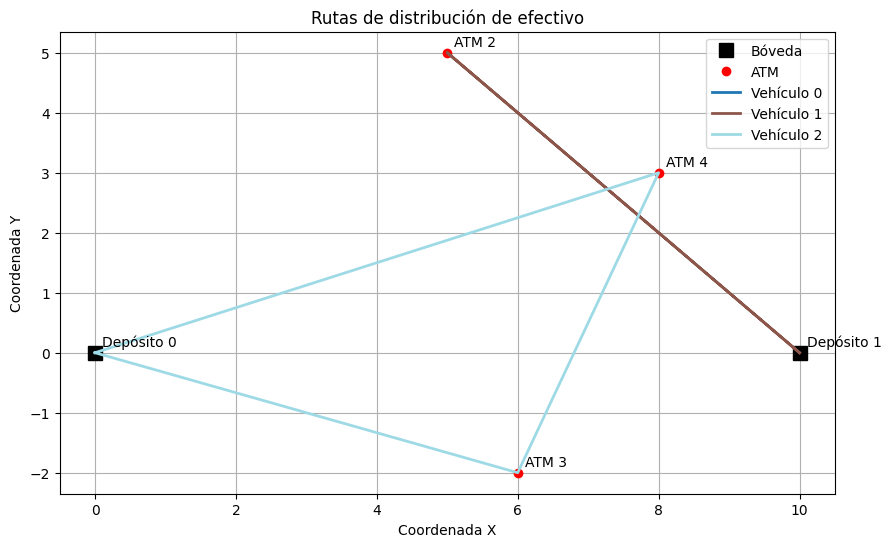

In [14]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt

def create_data_model():
    """Crea los datos del problema ajustados para reflejar la distribución de efectivo desde las bóvedas hasta los ATMs."""
    data = {}
    # Ubicaciones (latitud, longitud)
    data['locations'] = [
        (0.0, 0.0),    # Bóveda 1 (índice 0)
        (10.0, 0.0),   # Bóveda 2 (índice 1)
        (5.0, 5.0),    # ATM 1 (índice 2)
        (6.0, -2.0),   # ATM 2 (índice 3)
        (8.0, 3.0),    # ATM 3 (índice 4)
        # Puedes agregar más ATMs si lo deseas
    ]
    data['num_vehicles'] = 3  # Número de vehículos de transporte de efectivo
    data['depot_indices'] = [0, 1]  # Índices de las bóvedas
    data['vehicle_starts'] = [0, 1, 0]  # Vehículos empiezan en las bóvedas
    data['vehicle_ends'] = [0, 1, 0]    # Vehículos regresan a las bóvedas

    # Demanda en cada ubicación
    # Demanda positiva para ATMs (efectivo que necesitan)
    # Demanda cero en las bóvedas
    data['demands'] = [
        0,    # Bóveda 1
        0,    # Bóveda 2
        20,   # ATM 1 necesita 20 unidades de efectivo
        15,   # ATM 2 necesita 15 unidades de efectivo
        10,   # ATM 3 necesita 10 unidades de efectivo
        # Agrega más demandas si hay más ATMs
    ]

    # Capacidad de los vehículos (máxima cantidad de efectivo que pueden transportar)
    data['vehicle_capacities'] = [50, 50, 50]

    # Ventanas de tiempo para cada ubicación (en minutos)
    data['time_windows'] = [
        (0, 480),   # Bóveda 1 abierta de 0 a 480 minutos (8 horas)
        (0, 480),   # Bóveda 2 abierta de 0 a 480 minutos
        (60, 300),  # ATM 1 debe ser abastecido entre 1h y 5h
        (120, 360), # ATM 2 entre 2h y 6h
        (90, 330),  # ATM 3 entre 1.5h y 5.5h
        # Agrega ventanas de tiempo para más ATMs si es necesario
    ]

    # Tiempos de servicio en cada ubicación (en minutos)
    data['service_times'] = [
        0,    # Bóveda 1
        0,    # Bóveda 2
        15,   # ATM 1
        15,   # ATM 2
        15,   # ATM 3
        # Agrega tiempos de servicio para más ATMs si es necesario
    ]

    # Matriz de distancias (calculada usando la distancia euclidiana)
    data['distance_matrix'] = compute_distance_matrix(data['locations'])

    # Costos fijos asociados al servicio de cada ATM (por ejemplo, costos de abastecimiento)
    data['fixed_cost_per_atm'] = 100

    # Índices de los ATMs
    data['atm_indices'] = [2, 3, 4]

    return data

def compute_distance_matrix(locations):
    """Calcula la matriz de distancias entre ubicaciones."""
    num_locations = len(locations)
    distance_matrix = []
    for from_idx in range(num_locations):
        row = []
        from_loc = locations[from_idx]
        for to_idx in range(num_locations):
            to_loc = locations[to_idx]
            # Calcula la distancia euclidiana
            distance = ((from_loc[0] - to_loc[0])**2 + (from_loc[1] - to_loc[1])**2)**0.5
            # Puedes ajustar el factor multiplicador según la unidad de costo o tiempo
            row.append(distance)
        distance_matrix.append(row)
    return distance_matrix

def main():
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'],
                                           data['vehicle_starts'],
                                           data['vehicle_ends'])
    routing = pywrapcp.RoutingModel(manager)

    # Función de costo ajustada
    def cost_callback(from_index, to_index):
        """Retorna el costo de ir del nodo 'from_index' al nodo 'to_index'."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        distance_cost = data['distance_matrix'][from_node][to_node]
        fixed_cost = 0
        if from_node in data['atm_indices']:
            fixed_cost += data['fixed_cost_per_atm']
        return distance_cost + fixed_cost

    cost_callback_index = routing.RegisterTransitCallback(cost_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(cost_callback_index)

    # Restricciones de capacidad
    def demand_callback(from_index):
        """Retorna la demanda en cada nodo."""
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # Sin holgura
        data['vehicle_capacities'],  # Capacidades de los vehículos
        True,  # Acumulación desde el inicio
        'Capacity')
    capacity_dimension = routing.GetDimensionOrDie('Capacity')

    # Restricciones de ventanas de tiempo
    def time_callback(from_index, to_index):
        """Retorna el tiempo de viaje entre dos nodos."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        travel_time = data['distance_matrix'][from_node][to_node]
        service_time = data['service_times'][from_node]
        return travel_time + service_time

    time_callback_index = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(
        time_callback_index,
        480,  # Holgura máxima (por ejemplo, tiempo de espera)
        480,  # Tiempo máximo permitido por ruta
        False,  # No forzar que los vehículos empiecen en tiempo cero
        'Time')
    time_dimension = routing.GetDimensionOrDie('Time')

    # Agregar ventanas de tiempo para cada ubicación
    for location_idx, time_window in enumerate(data['time_windows']):
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])

    # Restricción de máximo de ATMs por vehículo
    # En este ejemplo, limitamos a máximo 2 ATMs por vehículo
    def atm_count_callback(from_index):
        """Devuelve 1 si el nodo es un ATM, 0 en caso contrario."""
        from_node = manager.IndexToNode(from_index)
        if from_node in data['atm_indices']:
            return 1
        else:
            return 0

    atm_count_callback_index = routing.RegisterUnaryTransitCallback(atm_count_callback)
    routing.AddDimension(
        atm_count_callback_index,
        0,  # Sin holgura
        2,  # Máximo de ATMs por vehículo
        True,
        'ATM_Count')
    atm_count_dimension = routing.GetDimensionOrDie('ATM_Count')

    # Parámetros de búsqueda
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.FromSeconds(60)
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Resolver el problema
    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        print_solution(data, manager, routing, solution)
        plot_solution(data, manager, routing, solution)
    else:
        print('No se encontró una solución factible.')

def print_solution(data, manager, routing, solution):
    """Imprime la solución encontrada."""
    time_dimension = routing.GetDimensionOrDie('Time')
    capacity_dimension = routing.GetDimensionOrDie('Capacity')
    atm_count_dimension = routing.GetDimensionOrDie('ATM_Count')
    total_distance = 0
    total_fixed_cost = 0
    total_cost = 0

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Ruta para el vehículo {}:\n'.format(vehicle_id)
        route_distance = 0
        route_fixed_cost = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            next_index = solution.Value(routing.NextVar(index))
            next_node_index = manager.IndexToNode(next_index)
            distance = data['distance_matrix'][node_index][next_node_index]
            route_distance += distance
            if node_index in data['atm_indices']:
                route_fixed_cost += data['fixed_cost_per_atm']
            time_var = time_dimension.CumulVar(index)
            load_var = capacity_dimension.CumulVar(index)
            atm_count_var = atm_count_dimension.CumulVar(index)
            plan_output += ' {0} Time({1}) Load({2}) ATMs Visited({3}) ->'.format(
                node_index,
                solution.Value(time_var),
                solution.Value(load_var),
                solution.Value(atm_count_var))
            index = next_index
        node_index = manager.IndexToNode(index)
        plan_output += ' {0}\n'.format(node_index)
        plan_output += 'Distancia de la ruta: {:.2f} unidades\n'.format(route_distance)
        plan_output += 'Costo fijo de la ruta: {}\n'.format(route_fixed_cost)
        plan_output += 'Costo total de la ruta: {:.2f}\n'.format(route_distance + route_fixed_cost)
        print(plan_output)
        total_distance += route_distance
        total_fixed_cost += route_fixed_cost
    total_cost = total_distance + total_fixed_cost
    print('Distancia total de todas las rutas: {:.2f} unidades'.format(total_distance))
    print('Costo fijo total de todas las rutas: {}'.format(total_fixed_cost))
    print('Costo total de todas las rutas: {:.2f}'.format(total_cost))

def plot_solution(data, manager, routing, solution):
    """Grafica la solución encontrada."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Obtener coordenadas
    locations = data['locations']
    depot_indices = data['depot_indices']
    atm_indices = data['atm_indices']

    # Crear un mapa de colores para los vehículos
    colors = plt.cm.get_cmap('tab20', data['num_vehicles'])

    plt.figure(figsize=(10, 6))
    plt.title('Rutas de distribución de efectivo')

    # Graficar las ubicaciones
    for idx, location in enumerate(locations):
        if idx in depot_indices:
            plt.plot(location[0], location[1], 'ks', markersize=10, label='Bóveda' if idx == depot_indices[0] else "")
            plt.text(location[0]+0.1, location[1]+0.1, f'Depósito {idx}')
        elif idx in atm_indices:
            plt.plot(location[0], location[1], 'ro', markersize=6, label='ATM' if idx == atm_indices[0] else "")
            plt.text(location[0]+0.1, location[1]+0.1, f'ATM {idx}')
        else:
            plt.plot(location[0], location[1], 'bo', markersize=6, label='Otro' if idx == 0 else "")
            plt.text(location[0]+0.1, location[1]+0.1, f'Punto {idx}')

    # Graficar las rutas
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(locations[node_index])
            index = solution.Value(routing.NextVar(index))
        node_index = manager.IndexToNode(index)
        route.append(locations[node_index])
        route = np.array(route)
        plt.plot(route[:, 0], route[:, 1], color=colors(vehicle_id), linewidth=2, label=f'Vehículo {vehicle_id}')

    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()


Ruta para el vehículo 0:
 0 Time(0) Load(0) Sites Visited(0) -> 0
Distancia de la ruta: 0.00 unidades
Costo fijo de la ruta: 0
Costo total de la ruta: 0.00

Ruta para el vehículo 1:
 0 Time(0) Load(0) Sites Visited(0) -> 1 Time(60) Load(0) Sites Visited(0) -> 0
Distancia de la ruta: 14.14 unidades
Costo fijo de la ruta: 150
Costo total de la ruta: 164.14

Ruta para el vehículo 2:
 0 Time(0) Load(0) Sites Visited(0) -> 3 Time(120) Load(0) Sites Visited(0) -> 2 Time(120) Load(35) Sites Visited(1) -> 0
Distancia de la ruta: 20.25 unidades
Costo fijo de la ruta: 300
Costo total de la ruta: 320.25

Distancia total de todas las rutas: 34.40 unidades
Costo fijo total de todas las rutas: 450
Costo total de todas las rutas: 484.40


<ipython-input-15-88e2f0102bab>:224: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', data['num_vehicles'])


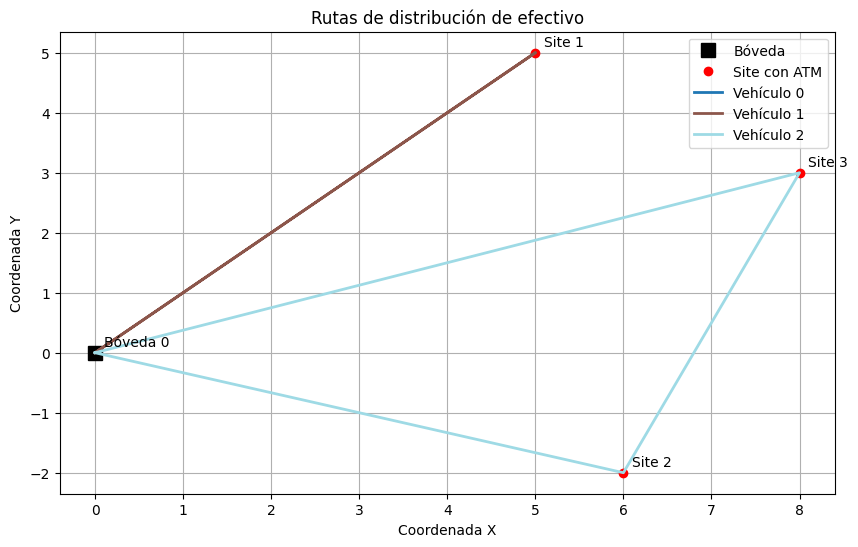

In [15]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt

def create_data_model():
    """Crea los datos del problema considerando que los ATMs están dentro de los Sites."""
    data = {}
    # Ubicaciones (latitud, longitud)
    data['locations'] = [
        (0.0, 0.0),    # Bóveda de la ETV (índice 0)
        # Sites (agencias bancarias con ATMs dentro)
        (5.0, 5.0),    # Site 1 con ATM 1 (índice 1)
        (6.0, -2.0),   # Site 2 con ATM 2 (índice 2)
        (8.0, 3.0),    # Site 3 con ATM 3 (índice 3)
        # Puedes agregar más Sites si lo deseas
    ]
    data['num_vehicles'] = 3
    data['depot'] = 0  # La bóveda de la ETV es el depósito
    data['vehicle_starts'] = [0, 0, 0]  # Todos los vehículos salen de la bóveda
    data['vehicle_ends'] = [0, 0, 0]    # Todos los vehículos regresan a la bóveda

    # Demandas en cada ubicación (demanda del Site + ATM)
    # Demanda positiva para abastecimiento (ventanillas y ATM)
    data['demands'] = [
        0,     # Bóveda
        50,    # Site 1 (ventanillas + ATM 1)
        40,    # Site 2 (ventanillas + ATM 2)
        35,    # Site 3 (ventanillas + ATM 3)
        # Agrega más demandas si hay más Sites
    ]

    # Capacidad de los vehículos
    data['vehicle_capacities'] = [100, 100, 100]

    # Ventanas de tiempo (en minutos)
    data['time_windows'] = [
        (0, 480),   # Bóveda (horario de 8 horas)
        (60, 360),  # Site 1
        (90, 390),  # Site 2
        (120, 420), # Site 3
    ]

    # Tiempos de servicio (tiempo para ventanillas + ATM)
    data['service_times'] = [
        0,    # Bóveda
        35,   # Site 1 (20 min ventanillas + 15 min ATM)
        35,   # Site 2 (20 min ventanillas + 15 min ATM)
        35,   # Site 3 (20 min ventanillas + 15 min ATM)
    ]

    # Matriz de distancias
    data['distance_matrix'] = compute_distance_matrix(data['locations'])

    # Costos fijos por servicio (pueden diferir)
    data['fixed_cost_per_site'] = 150  # Incluye costo de ventanillas y ATM

    # Índices de los Sites
    data['site_indices'] = [1, 2, 3]

    # Límite de 3 Sites por turno
    data['max_sites_per_shift'] = 3

    # Turnos (en minutos)
    data['shifts'] = [
        (0, 240),    # Turno 1: 0h a 4h
        (240, 480),  # Turno 2: 4h a 8h
    ]

    return data

def compute_distance_matrix(locations):
    num_locations = len(locations)
    distance_matrix = []
    for from_idx in range(num_locations):
        row = []
        from_loc = locations[from_idx]
        for to_idx in range(num_locations):
            to_loc = locations[to_idx]
            distance = ((from_loc[0] - to_loc[0])**2 + (from_loc[1] - to_loc[1])**2)**0.5
            row.append(distance)
        distance_matrix.append(row)
    return distance_matrix

def main():
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'],
                                           data['vehicle_starts'],
                                           data['vehicle_ends'])
    routing = pywrapcp.RoutingModel(manager)

    # Función de costo
    def cost_callback(from_index, to_index):
        """Costo de transporte más costos fijos."""
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        distance_cost = data['distance_matrix'][from_node][to_node]
        fixed_cost = 0
        if from_node in data['site_indices']:
            fixed_cost += data['fixed_cost_per_site']
        return distance_cost + fixed_cost

    cost_callback_index = routing.RegisterTransitCallback(cost_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(cost_callback_index)

    # Restricciones de capacidad
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,
        data['vehicle_capacities'],
        True,
        'Capacity')
    capacity_dimension = routing.GetDimensionOrDie('Capacity')

    # Restricciones de ventanas de tiempo
    def time_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        travel_time = data['distance_matrix'][from_node][to_node]
        service_time = data['service_times'][from_node]
        return travel_time + service_time

    time_callback_index = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(
        time_callback_index,
        480,  # Holgura máxima
        480,  # Tiempo máximo
        False,
        'Time')
    time_dimension = routing.GetDimensionOrDie('Time')

    # Ventanas de tiempo para cada ubicación
    for location_idx, time_window in enumerate(data['time_windows']):
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])

    # Restricción de máximo 3 Sites por turno
    def site_count_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        if from_node in data['site_indices']:
            return 1
        else:
            return 0

    site_count_callback_index = routing.RegisterUnaryTransitCallback(site_count_callback)
    routing.AddDimension(
        site_count_callback_index,
        0,
        data['max_sites_per_shift'],
        True,
        'Site_Count')
    site_count_dimension = routing.GetDimensionOrDie('Site_Count')

    # Parámetros de búsqueda
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.FromSeconds(60)
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Resolver el problema
    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        print_solution(data, manager, routing, solution)
        plot_solution(data, manager, routing, solution)
    else:
        print('No se encontró una solución factible.')

def print_solution(data, manager, routing, solution):
    time_dimension = routing.GetDimensionOrDie('Time')
    capacity_dimension = routing.GetDimensionOrDie('Capacity')
    site_count_dimension = routing.GetDimensionOrDie('Site_Count')
    total_distance = 0
    total_fixed_cost = 0
    total_cost = 0

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Ruta para el vehículo {}:\n'.format(vehicle_id)
        route_distance = 0
        route_fixed_cost = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            next_index = solution.Value(routing.NextVar(index))
            next_node_index = manager.IndexToNode(next_index)
            distance = data['distance_matrix'][node_index][next_node_index]
            route_distance += distance
            if node_index in data['site_indices']:
                route_fixed_cost += data['fixed_cost_per_site']
            time_var = time_dimension.CumulVar(index)
            load_var = capacity_dimension.CumulVar(index)
            site_count_var = site_count_dimension.CumulVar(index)
            plan_output += ' {0} Time({1}) Load({2}) Sites Visited({3}) ->'.format(
                node_index,
                solution.Value(time_var),
                solution.Value(load_var),
                solution.Value(site_count_var))
            index = next_index
        node_index = manager.IndexToNode(index)
        plan_output += ' {0}\n'.format(node_index)
        plan_output += 'Distancia de la ruta: {:.2f} unidades\n'.format(route_distance)
        plan_output += 'Costo fijo de la ruta: {}\n'.format(route_fixed_cost)
        plan_output += 'Costo total de la ruta: {:.2f}\n'.format(route_distance + route_fixed_cost)
        print(plan_output)
        total_distance += route_distance
        total_fixed_cost += route_fixed_cost
    total_cost = total_distance + total_fixed_cost
    print('Distancia total de todas las rutas: {:.2f} unidades'.format(total_distance))
    print('Costo fijo total de todas las rutas: {}'.format(total_fixed_cost))
    print('Costo total de todas las rutas: {:.2f}'.format(total_cost))

def plot_solution(data, manager, routing, solution):
    import matplotlib.pyplot as plt
    import numpy as np

    locations = data['locations']
    depot_index = data['depot']
    site_indices = data['site_indices']

    colors = plt.cm.get_cmap('tab20', data['num_vehicles'])

    plt.figure(figsize=(10, 6))
    plt.title('Rutas de distribución de efectivo')

    for idx, location in enumerate(locations):
        if idx == depot_index:
            plt.plot(location[0], location[1], 'ks', markersize=10, label='Bóveda' if idx == depot_index else "")
            plt.text(location[0]+0.1, location[1]+0.1, f'Bóveda {idx}')
        elif idx in site_indices:
            plt.plot(location[0], location[1], 'ro', markersize=6, label='Site con ATM' if idx == site_indices[0] else "")
            plt.text(location[0]+0.1, location[1]+0.1, f'Site {idx}')
        else:
            plt.plot(location[0], location[1], 'bo', markersize=6)
            plt.text(location[0]+0.1, location[1]+0.1, f'Punto {idx}')

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(locations[node_index])
            index = solution.Value(routing.NextVar(index))
        node_index = manager.IndexToNode(index)
        route.append(locations[node_index])
        route = np.array(route)
        plt.plot(route[:, 0], route[:, 1], color=colors(vehicle_id), linewidth=2, label=f'Vehículo {vehicle_id}')

    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()


Ruta para el vehículo 0:
- Sale de la Bóveda con carga inicial de 77 unidades de efectivo.
- Llega al Site 2 a tiempo 80 minutos.
  Recoge 50 unidades de efectivo en el Site 2.
  Carga antes de visita: 77 unidades.
  Carga después de visita: 77 unidades.
- Llega al Site 3 a tiempo 135 minutos.
  Deja 100 unidades de efectivo en el Site 3.
  Carga antes de visita: 77 unidades.
  Carga después de visita: 127 unidades.
- Regresa a la Bóveda con carga final de 27 unidades de efectivo.
Distancia total de la ruta: 11.71 unidades.
Efectivo entregado: 100 unidades.
Efectivo recogido: 50 unidades.

Ruta para el vehículo 1:
- Sale de la Bóveda con carga inicial de 77 unidades de efectivo.
- Llega al Site 5 a tiempo 140 minutos.
  Deja 70 unidades de efectivo en el Site 5.
  Carga antes de visita: 77 unidades.
  Carga después de visita: 77 unidades.
- Regresa a la Bóveda con carga final de 7 unidades de efectivo.
Distancia total de la ruta: 5.39 unidades.
Efectivo entregado: 70 unidades.
Efectivo

C:\Users\mango\AppData\Local\Temp\ipykernel_9748\3029590044.py:227: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', data['num_vehicles'])


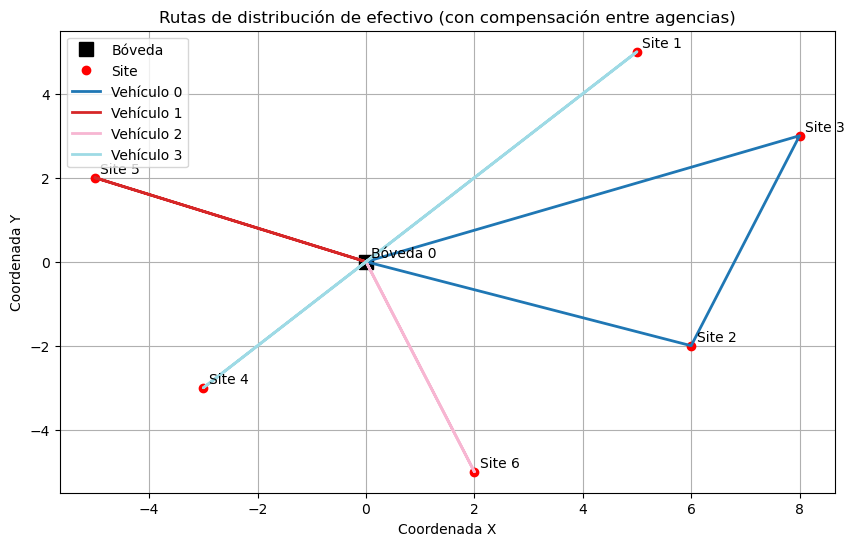

In [7]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt

def create_data_model():
    data = {}
    data['locations'] = [
        (0.0, 0.0),     # Bóveda (índice 0)
        (5.0, 5.0),     # Site 1 (índice 1)
        (6.0, -2.0),    # Site 2 (índice 2)
        (8.0, 3.0),     # Site 3 (índice 3)
        (-3.0, -3.0),   # Site 4 (índice 4)
        (-5.0, 2.0),    # Site 5 (índice 5)
        (2.0, -5.0),    # Site 6 (índice 6)
    ]
    data['num_vehicles'] = 4
    data['depot'] = 0

    # Demandas en cada Site (positivas para recolecciones, negativas para entregas)
    data['demands'] = [
        0,      # Bóveda
        -80,    # Site 1 necesita 80 unidades de efectivo (entrega)
        50,     # Site 2 tiene un exceso de 50 unidades (recolección)
        -100,   # Site 3 necesita 100 unidades de efectivo (entrega)
        30,     # Site 4 tiene un exceso de 30 unidades (recolección)
        -70,    # Site 5 necesita 70 unidades de efectivo (entrega)
        -60,    # Site 6 necesita 60 unidades de efectivo (entrega)
    ]

    data['service_times'] = [
        0,      # Bóveda
        55,     # Site 1
        50,     # Site 2
        60,     # Site 3
        40,     # Site 4
        50,     # Site 5
        45,     # Site 6
    ]

    data['time_windows'] = [
        (0, 480),     # Bóveda
        (60, 300),    # Site 1
        (80, 320),    # Site 2
        (100, 340),   # Site 3
        (120, 360),   # Site 4
        (140, 380),   # Site 5
        (160, 400),   # Site 6
    ]

    data['vehicle_capacities'] = [200, 200, 200, 200]

    data['distance_matrix'] = compute_distance_matrix(data['locations'])

    data['site_atm_counts'] = {
        1: 3,
        2: 2,
        3: 3,
        4: 1,
        5: 2,
        6: 2,
    }

    data['max_atms_per_shift'] = 5

    return data

def compute_distance_matrix(locations):
    num_locations = len(locations)
    distance_matrix = []
    for from_idx in range(num_locations):
        row = []
        from_loc = locations[from_idx]
        for to_idx in range(num_locations):
            to_loc = locations[to_idx]
            distance = ((from_loc[0] - to_loc[0])**2 + (from_loc[1] - to_loc[1])**2)**0.5
            row.append(distance)
        distance_matrix.append(row)
    return distance_matrix

def main():
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'],
                                           data['depot'])
    routing = pywrapcp.RoutingModel(manager)

    def cost_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(data['distance_matrix'][from_node][to_node])

    transit_callback_index = routing.RegisterTransitCallback(cost_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)

    # Change fix_start_cumul_to_zero to False
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,
        data['vehicle_capacities'],
        False,  # Allow non-zero initial load
        'Capacity')

    capacity_dimension = routing.GetDimensionOrDie('Capacity')

    # Calculate the initial load per vehicle
    total_delivery_demand = -sum([d for d in data['demands'] if d < 0])
    initial_load = total_delivery_demand // data['num_vehicles']

    # Ensure initial load does not exceed vehicle capacity
    if initial_load > min(data['vehicle_capacities']):
        print("Error: Initial load exceeds vehicle capacity.")
        return

    # Set initial load for each vehicle
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        capacity_dimension.CumulVar(index).SetValue(initial_load)

    def time_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        travel_time = int(data['distance_matrix'][from_node][to_node])
        service_time = data['service_times'][from_node]
        return travel_time + service_time

    time_callback_index = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(
        time_callback_index,
        480,
        480,
        False,
        'Time')

    time_dimension = routing.GetDimensionOrDie('Time')

    for location_idx, time_window in enumerate(data['time_windows']):
        index = manager.NodeToIndex(location_idx)
        time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])

    def atm_count_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['site_atm_counts'].get(from_node, 0)

    atm_count_callback_index = routing.RegisterUnaryTransitCallback(atm_count_callback)
    routing.AddDimension(
        atm_count_callback_index,
        0,
        data['max_atms_per_shift'],
        True,
        'ATM_Count')

    atm_count_dimension = routing.GetDimensionOrDie('ATM_Count')

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.time_limit.FromSeconds(120)
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        print_solution(data, manager, routing, solution)
        plot_solution(data, manager, routing, solution)
    else:
        print('No se encontró una solución factible.')

def print_solution(data, manager, routing, solution):
    time_dimension = routing.GetDimensionOrDie('Time')
    capacity_dimension = routing.GetDimensionOrDie('Capacity')
    total_distance = 0

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        if routing.IsEnd(solution.Value(routing.NextVar(index))):
            continue
        print(f'Ruta para el vehículo {vehicle_id}:')
        plan_output = ''
        route_distance = 0
        total_delivery = 0
        total_pickup = 0
        load = solution.Value(capacity_dimension.CumulVar(index))
        plan_output += f'- Sale de la Bóveda con carga inicial de {load} unidades de efectivo.\n'
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            prev_load = load
            prev_index = index
            index = solution.Value(routing.NextVar(index))
            load = solution.Value(capacity_dimension.CumulVar(index))
            demand = data['demands'][manager.IndexToNode(index)]
            time = solution.Value(time_dimension.CumulVar(index))

            if manager.IndexToNode(index) != data['depot']:
                operation = ''
                if demand < 0:
                    operation = f'Deja {abs(demand)} unidades de efectivo en el Site {manager.IndexToNode(index)}.'
                    total_delivery += abs(demand)
                elif demand > 0:
                    operation = f'Recoge {demand} unidades de efectivo en el Site {manager.IndexToNode(index)}.'
                    total_pickup += demand

                plan_output += (f'- Llega al Site {manager.IndexToNode(index)} a tiempo {time} minutos.\n'
                                f'  {operation}\n'
                                f'  Carga antes de visita: {prev_load} unidades.\n'
                                f'  Carga después de visita: {load} unidades.\n')

            if not routing.IsEnd(index):
                route_distance += data['distance_matrix'][manager.IndexToNode(prev_index)][manager.IndexToNode(index)]
        plan_output += f'- Regresa a la Bóveda con carga final de {load} unidades de efectivo.\n'
        plan_output += f'Distancia total de la ruta: {route_distance:.2f} unidades.\n'
        plan_output += f'Efectivo entregado: {total_delivery} unidades.\n'
        plan_output += f'Efectivo recogido: {total_pickup} unidades.\n'
        print(plan_output)
        total_distance += route_distance
    print(f'Distancia total de todas las rutas: {total_distance:.2f} unidades')

def plot_solution(data, manager, routing, solution):
    import numpy as np

    locations = data['locations']
    depot_index = data['depot']

    colors = plt.cm.get_cmap('tab20', data['num_vehicles'])

    plt.figure(figsize=(10, 6))
    plt.title('Rutas de distribución de efectivo (con compensación entre agencias)')

    for idx, location in enumerate(locations):
        if idx == depot_index:
            plt.plot(location[0], location[1], 'ks', markersize=10, label='Bóveda' if idx == depot_index else "")
            plt.text(location[0]+0.1, location[1]+0.1, f'Bóveda {idx}')
        else:
            plt.plot(location[0], location[1], 'ro', markersize=6, label='Site' if idx == 1 else "")
            plt.text(location[0]+0.1, location[1]+0.1, f'Site {idx}')

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        if routing.IsEnd(solution.Value(routing.NextVar(index))):
            continue  # Vehículo no utilizado
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(locations[node_index])
            index = solution.Value(routing.NextVar(index))
        node_index = manager.IndexToNode(index)
        route.append(locations[node_index])
        route = np.array(route)
        plt.plot(route[:, 0], route[:, 1], color=colors(vehicle_id), linewidth=2, label=f'Vehículo {vehicle_id}')

    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    main()
